# Finale Testläufe mit dem kombinierten Modell (Klassifikation + Regression)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor

from fraud_detection import data_loader, metrics

datapath = "../data/transformed_label_and_damage.parquet"

In [10]:
seed = 42
np.random.seed(seed)


In [11]:
def cost_fn(probs, damage, cost_fp, tain_tp=5):
    return probs > cost_fp / (tain_tp + cost_fp + damage)

In [12]:
def get_balanced_data(X_train, y_train, seed=42):
    n_damage = np.sum(y_train[:, 1] > 0)
    n_no_damage = np.sum(y_train[:, 1] == 0)
    n_samples = min(n_damage, n_no_damage)
    idx_balanced = np.concatenate([
            np.random.choice(np.where(y_train[:, 1] > 0)[0], n_samples, replace=False),
            np.random.choice(np.where(y_train[:, 1] == 0)[0], n_samples, replace=False),
    ])
    X_train = X_train[idx_balanced]
    y_train = y_train[idx_balanced]
    return X_train, y_train


def get_data_with_damage_only(X_train, y_train):
    idx_damage = np.where(y_train[:, 1] > 0)[0]
    X_damage = X_train[idx_damage,:]
    y_damage = y_train[idx_damage,:]
    return X_damage, y_damage


def id(X, y):
    return X, y

In [13]:
X, targets = data_loader.load_data_np(datapath, drop_features=data_loader.useless_features)

In [14]:
def fit_regressor_and_predict(X_train, y_train, X_test, y_test, traindata_function: callable):
    X_train, y_train = traindata_function(X_train, y_train)

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
    )

    #sample_weights = np.where(y_train[:, 0] > 0, 200.0, 1.0)
    model.fit(X_train, y_train[:, 1])#, sample_weight=sample_weights)

    #model.fit(X_train, y_train[:, 1])
    preds = model.predict(X_test)
    bew = metrics.regression(preds, y_test[:, 1])

    return model, bew, preds

In [49]:
def create_and_evaluate_model(X_train, y_train, X_test, y_test, train_data_function: callable):
    threshold = 0.0
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="binary:logistic",
    )
    clf.fit(X_train, y_train[:, 0])
    probs_baseline = clf.predict_proba(X_test)[:, 1]
    preds_baseline = clf.predict(X_test)

    metrics_baseline = metrics.bewertung(probs_baseline, preds_baseline, y_test[:, 0], y_test[:, 1])

    model, bew, preds = fit_regressor_and_predict(X_train, y_train, X_test, y_test, train_data_function)

    damage_preds = model.predict(X_test)

    preds = (probs_baseline > threshold) & cost_fn(probs_baseline, damage_preds, 10)
    metrics_combined = metrics.bewertung(probs_baseline, preds, y_test[:, 0], y_test[:, 1])

    return damage_preds, metrics_baseline, metrics_combined


In [50]:
def run_experiment(X, targets, train_data_function, n_splits=5, n_repeats=1, random_state=42):

    # Initialize the RepeatedStratifiedKFold
    skf = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )

    df = pd.DataFrame()

    for i, (train_idx, test_idx) in enumerate(skf.split(X, targets[:, 0])):
        print(f"Fold {i + 1}/{n_splits * n_repeats}")
        _, m_base, m_comb = create_and_evaluate_model(
            X[train_idx],
            targets[train_idx],
            X[test_idx],
            targets[test_idx],
            train_data_function,
        )
        res = {
         "precision_baseline": m_base["precision"],
         "recall_baseline": m_base["recall"],

         "recall_combined": m_comb["recall"],
         "precision_combined": m_comb["precision"],

         "true_positives_baseline": m_base["cm"][1, 1],
         "false_positives_baseline": m_base["cm"][0, 1],
         "true_positives_combined": m_comb["cm"][1, 1],
         "false_positives_combined": m_comb["cm"][0, 1],

         "damage_in_test_set": m_base["damage_total"],
         "damage_prevented_baseline": m_base["damage_prevented"],
         "damage_prevented_combined": m_comb["damage_prevented"],

         "bewertung_baseline": m_base["Bewertung"],
         "bewertung_combined": m_comb["Bewertung"],
         "difference_bewertung": m_comb["Bewertung"] - m_base["Bewertung"],
        }
        df_fold = pd.DataFrame(res, index=[f"Fold {i + 1}"])
        df = pd.concat([df, df_fold], axis=0)

    return df


In [51]:
n_splits = 5
n_repeats = 40

df = run_experiment(X, targets, id, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
df_balance = run_experiment(X, targets, get_balanced_data, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
df_damage = run_experiment(X, targets, get_data_with_damage_only, n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

Fold 1/200


Fold 2/200
Fold 3/200
Fold 4/200
Fold 5/200
Fold 6/200
Fold 7/200
Fold 8/200
Fold 9/200
Fold 10/200
Fold 11/200
Fold 12/200
Fold 13/200
Fold 14/200
Fold 15/200
Fold 16/200
Fold 17/200
Fold 18/200
Fold 19/200
Fold 20/200
Fold 21/200
Fold 22/200
Fold 23/200
Fold 24/200
Fold 25/200
Fold 26/200
Fold 27/200
Fold 28/200
Fold 29/200
Fold 30/200
Fold 31/200
Fold 32/200
Fold 33/200
Fold 34/200
Fold 35/200
Fold 36/200
Fold 37/200
Fold 38/200
Fold 39/200
Fold 40/200
Fold 41/200
Fold 42/200
Fold 43/200
Fold 44/200
Fold 45/200
Fold 46/200
Fold 47/200
Fold 48/200
Fold 49/200
Fold 50/200
Fold 51/200
Fold 52/200
Fold 53/200
Fold 54/200
Fold 55/200
Fold 56/200
Fold 57/200
Fold 58/200
Fold 59/200
Fold 60/200
Fold 61/200
Fold 62/200
Fold 63/200
Fold 64/200
Fold 65/200
Fold 66/200
Fold 67/200
Fold 68/200
Fold 69/200
Fold 70/200
Fold 71/200
Fold 72/200
Fold 73/200
Fold 74/200
Fold 75/200
Fold 76/200
Fold 77/200
Fold 78/200
Fold 79/200
Fold 80/200
Fold 81/200
Fold 82/200
Fold 83/200
Fold 84/200
Fold 85/200


In [52]:
df_diff = pd.DataFrame({
    "Full": df.difference_bewertung.mean(),
    "Balanced": df_balance.difference_bewertung.mean(),
    "Damage Only": df_damage.difference_bewertung.mean(),
}, index=["Mittlere Differenz der Bewertung"]).T

In [54]:
df_diff.round(2)

,Mittlere Differenz der Bewertung
Full,-4.92
Balanced,7.71
Damage Only,4.02


In [55]:
df.describe().round(3).iloc[:, 12:-1]

,bewertung_combined
count,200.000
mean,-1005.266
std,207.630
min,-1704.390
25%,-1130.038
50%,-989.415
75%,-859.580
max,-482.450


In [57]:
df_balance.describe().round(3).iloc[:, 12:-1]

,bewertung_combined
count,200.000
mean,-992.640
std,213.102
min,-1749.870
25%,-1119.628
50%,-994.300
75%,-839.453
max,-413.680


In [59]:
df_damage.describe().round(3).iloc[:, 12:-1]

,bewertung_combined
count,200.000
mean,-996.326
std,214.318
min,-1774.870
25%,-1128.742
50%,-999.400
75%,-859.872
max,-428.380


In [67]:
df_x = df[["damage_in_test_set", "bewertung_baseline", "bewertung_combined"]].copy()
df_x["model_gain"] = df_x["damage_in_test_set"] + df_x["bewertung_baseline"]
df_x["model_gain_combined"] = df_x["damage_in_test_set"] + df_x["bewertung_combined"]
df_x["improvement_in_percent"] = df_x["model_gain_combined"] / df_x["model_gain"] * 100 - 100
df_x = df_x.rename(
    columns={
        "damage_in_test_set": "Ø Schaden im Testset",
        "bewertung_baseline": "Baseline",
        "bewertung_combined": "Kombiniertes Modell",
        "model_gain": "Modellgewinn",
        "model_gain_combined": "Modellgewinn (Kombiniertes Modell)",
        "improvement_in_percent": "Prozentuale Verbesserung",
    }
)
df_x.describe().round(3).iloc[1]

Ø Schaden im Testset                  6015.164
Baseline                             -1000.346
Kombiniertes Modell                  -1005.266
Modellgewinn                          5014.818
Modellgewinn (Kombiniertes Modell)    5009.898
Prozentuale Verbesserung                -0.087
Name: mean, dtype: float64

In [68]:
df.describe().round(3)[[c for c in df.columns if "recall" in c]]

,recall_baseline,recall_combined
count,200.000,200.000
mean,0.553,0.529
std,0.017,0.017
min,0.512,0.491
25%,0.540,0.516
50%,0.553,0.529
75%,0.563,0.542
max,0.605,0.582


In [69]:
df_balance.describe().round(3).iloc[:, 6:]

,true_positives_combined,false_positives_combined,damage_in_test_set,damage_prevented_baseline,damage_prevented_combined,bewertung_baseline,bewertung_combined,difference_bewertung
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,475.625,97.115,6015.164,3550.443,3615.549,-1000.346,-992.640,7.706
std,14.629,10.321,164.175,162.511,160.402,216.321,213.102,62.238
min,443.000,65.000,5552.660,3193.110,3253.180,-1783.540,-1749.870,-184.310
25%,465.000,91.000,5897.000,3431.742,3499.738,-1144.480,-1119.628,-37.225
50%,476.000,97.000,6017.510,3540.650,3602.910,-980.825,-994.300,9.670
75%,485.000,104.000,6136.938,3657.387,3738.135,-843.200,-839.453,47.245
max,518.000,126.000,6580.410,4241.240,4259.630,-512.710,-413.680,177.740


In [70]:
df_balance.describe().round(3).iloc[:, :6]

,precision_baseline,recall_baseline,recall_combined,precision_combined,true_positives_baseline,false_positives_baseline
count,200.000,200.000,200.000,200.000,200.000,200.000
mean,0.840,0.553,0.556,0.831,472.725,89.925
std,0.015,0.017,0.017,0.015,14.541,9.679
min,0.795,0.512,0.518,0.789,438.000,61.000
25%,0.831,0.540,0.544,0.821,462.000,84.000
50%,0.840,0.553,0.556,0.830,473.000,90.000
75%,0.849,0.563,0.567,0.840,482.000,95.000
max,0.881,0.605,0.606,0.873,517.000,115.000


In [71]:
df.to_csv("../csv/combined_model_regression_on_full_data.csv")
df_balance.to_csv("../csv/combined_model_regression_on_balanced_data.csv")
df_damage.to_csv("../csv/combined_model_regression_on_damage_only_data.csv")
df_diff.to_csv("../csv/combined_model_differences_summary.csv")

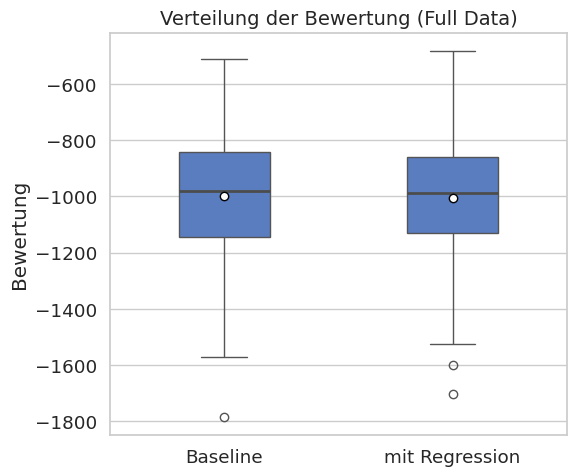

In [72]:
# Melt the DataFrame to long-form for Seaborn
df_melted = df[[c for c in df.columns if c.startswith("bewertung")]].rename(
    columns={
        "bewertung_baseline": "Baseline",
        "bewertung_combined": "mit Regression",
    }
)

df_melted = df_melted.melt(
    var_name="Kategorie", value_name="Bewertung"
)

# Set theme and font scale
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Create the box plot with Seaborn
plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df_melted,
    x="Kategorie",
    y="Bewertung",
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),  # dark gray
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),  # teal green
    notch=False,
)

# Improve axis labels and layout
ax.set_title("Verteilung der Bewertung (Full Data)", fontsize=14)
ax.set_xlabel("")  # Remove x-label since it's redundant
ax.set_ylabel("Bewertung")
#ax.tick_params(axis='x', rotation=45)  # Rotate x labels if they overlap

plt.tight_layout()
plt.show()

In [76]:
df_damage["recall_combined"]

Fold 1      0.556075
Fold 2      0.582944
Fold 3      0.555556
Fold 4      0.533333
Fold 5      0.570093
              ...   
Fold 196    0.572430
Fold 197    0.574766
Fold 198    0.571930
Fold 199    0.532164
Fold 200    0.574766
Name: recall_combined, Length: 200, dtype: float64

In [ ]:
def plot_recall_precision(df, df2):
    # Separate melted data (as you already have it)
    df_recall = df[[c for c in df.columns if c.startswith("recall")]].rename(
        columns={
            "recall_baseline": "Baseline",
            "recall_combined": "mit Regression",
        }
    ).melt(var_name="Kategorie", value_name="Wert")
    df_recall["Metrik"] = "Recall"

    df_precision = df[[c for c in df.columns if c.startswith("precision")]].rename(
        columns={
            "precision_baseline": "Baseline",
            "precision_combined": "mit Regression",
        }
    ).melt(var_name="Kategorie", value_name="Wert")
    df_precision["Metrik"] = "Precision"

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))

    # Plot Recall
    sns.boxplot(
        data=df_recall,
        x="Kategorie",
        y="Wert",
        ax=axes[0],
        palette="muted",
        width=0.4,
        showmeans=True,
        medianprops=dict(color="#4c4c4c", linewidth=2),
        meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
    )
    axes[0].set_title("Recall")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Wert")

    # Plot Precision
    sns.boxplot(
        data=df_precision,
        x="Kategorie",
        y="Wert",
        ax=axes[1],
        palette="muted",
        width=0.4,
        showmeans=True,
        medianprops=dict(color="#4c4c4c", linewidth=2),
        meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
    )
    axes[1].set_title("Precision")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")

    # Overall layout
    fig.suptitle("Verteilung von Recall und Precision (Full Data)", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


/tmp/ipykernel_81979/3083353895.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_81979/3083353895.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


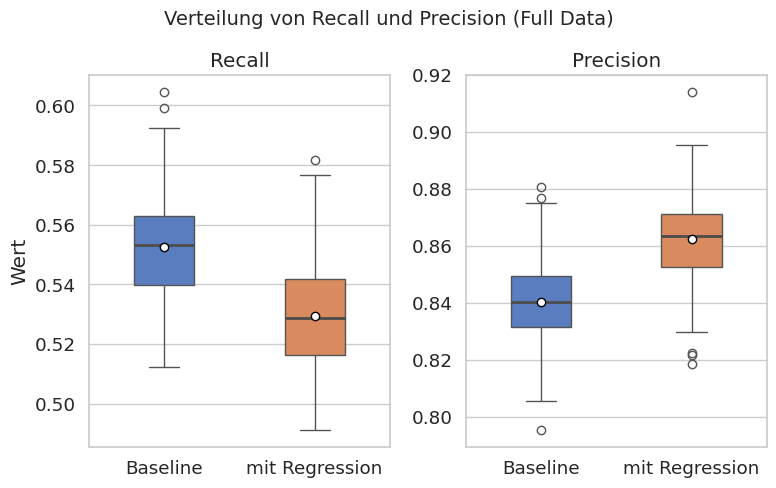

In [74]:
plot_recall_precision(df)

/tmp/ipykernel_81979/3083353895.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_81979/3083353895.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


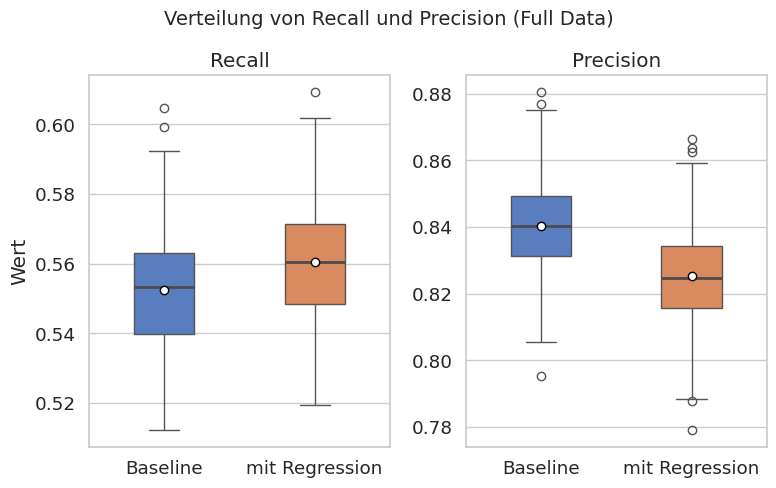

In [75]:
plot_recall_precision(df_damage)

/tmp/ipykernel_81979/290149356.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_81979/290149356.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


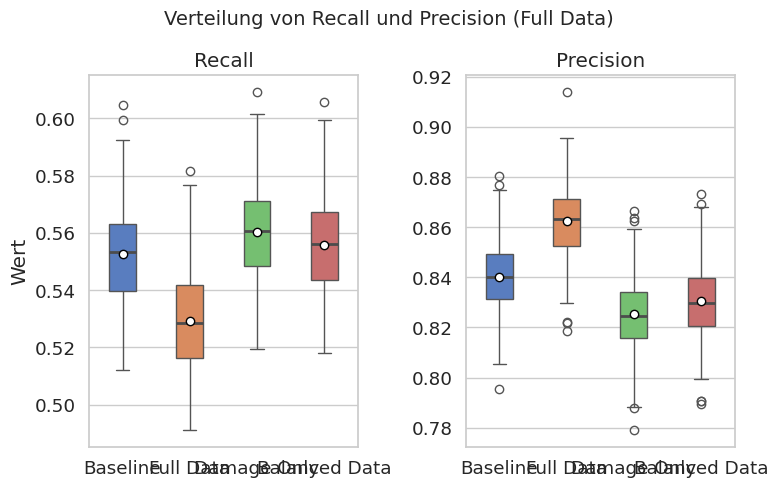

In [82]:
from matplotlib.patches import Patch

df_recall = df[["recall_baseline", "recall_combined"]].copy()
# add recall_combined from df_damage
df_recall["recall_damage"] = df_damage["recall_combined"]
df_recall["recall_balanced"] = df_balance["recall_combined"]
df_recall.rename(
    columns={
        "recall_baseline": "Baseline",
        "recall_combined": "Full Data",
        "recall_damage": "Damage Only",
        "recall_balanced": "Balanced Data",
    },
    inplace=True,
)
df_recall = df_recall.melt(
    var_name="Kategorie", value_name="Wert"
)
df_recall["Metrik"] = "Recall"

df_precision = df[["precision_baseline", "precision_combined"]].copy()
# add precision_combined from df_damage
df_precision["precision_damage"] = df_damage["precision_combined"]
df_precision["precision_balanced"] = df_balance["precision_combined"]
df_precision.rename(
    columns={
        "precision_baseline": "Baseline",
        "precision_combined": "Full Data",
        "precision_damage": "Damage Only",
        "precision_balanced": "Balanced Data",
    },
    inplace=True,
)
df_precision = df_precision.melt(
    var_name="Kategorie", value_name="Wert"
)
df_precision["Metrik"] = "Precision"

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Plot Recall
sns.boxplot(
    data=df_recall,
    x="Kategorie",
    y="Wert",
    ax=axes[0],
    palette="muted",
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
)
axes[0].set_title("Recall")
axes[0].set_xlabel("")
axes[0].set_ylabel("Wert")

# Plot Precision
sns.boxplot(
    data=df_precision,
    x="Kategorie",
    y="Wert",
    ax=axes[1],
    palette="muted",
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
)
axes[1].set_title("Precision")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Overall layout
fig.suptitle("Verteilung von Recall und Precision (Full Data)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


/tmp/ipykernel_81979/1286013697.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_81979/1286013697.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


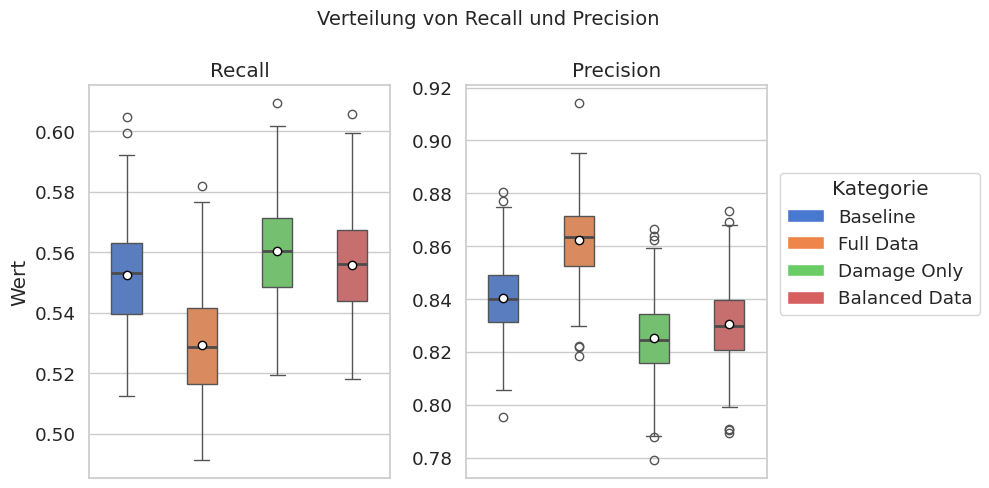

In [86]:
# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define color palette and categories
palette = sns.color_palette("muted")
categories = df_recall["Kategorie"].unique()
colors = dict(zip(categories, palette))

# Plot Recall
sns.boxplot(
    data=df_recall,
    x="Kategorie",
    y="Wert",
    ax=axes[0],
    palette=colors,
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
)
axes[0].set_title("Recall")
axes[0].set_xlabel("")
axes[0].set_ylabel("Wert")
axes[0].set_xticks([])  # Remove x-axis labels

# Plot Precision
sns.boxplot(
    data=df_precision,
    x="Kategorie",
    y="Wert",
    ax=axes[1],
    palette=colors,
    width=0.4,
    showmeans=True,
    medianprops=dict(color="#4c4c4c", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="white", markeredgecolor="black"),
)
axes[1].set_title("Precision")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_xticks([])  # Remove x-axis labels

# Create legend patches
legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in categories]

# Add legend to the right of both plots
fig.legend(handles=legend_elements, loc='center right', title="Kategorie")

# Overall layout
fig.suptitle("Verteilung von Recall und Precision", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.80, 1.])  # leave space for legend
plt.show()
